In [3]:
import sys
import pandas as pd
import numpy as np
from cycler import cycler

# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

pd.options.display.max_columns = 30
plt.ion()

plt.rcParams['figure.figsize'] = (16, 6)

import numpy as np

plt.style.use('ggplot')

# Set the default color cycle
plt.rc('axes', prop_cycle=(cycler('color', ['#65B278', 'b', 'b', 'y'])))



In [28]:
df = pd.read_csv('./data/monitoring-data.csv')

In [209]:
df.head()

,Units,Date,Month,Year,Date.1,Time,Temperature,Ph,Algae Coverage,Algae species,Fauna Species,Snails,Nerites,Crabs,Barnacles,Limpets,Landslugs,Tubeworm,Anemone,Shrimps,Bivalves,Ascidians,Sponge,Other
0,E9,18,3,2016,3/18/16,2:30:00 PM,38.4,NaN,90,1,1,2,10,0,0,0,0,0,0,0,0,0,0,0
1,E8,18,3,2016,3/18/16,2:35:00 PM,37.9,NaN,70,1,1,2,20,0,0,0,0,0,0,0,0,0,0,0
2,E7 (CON),18,3,2016,3/18/16,2:40:00 PM,35.2,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,E6,18,3,2016,3/18/16,2:45:00 PM,37.9,NaN,20,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,E5,18,3,2016,3/18/16,2:50:00 PM,37.8,NaN,20,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [210]:
df['Fauna Species'].value_counts()

3    59
2    47
1    41
4    36
0    33
5    14
6    13
8     2
7     2
Name: Fauna Species, dtype: int64

## Data cleaning

In [29]:
temp = pd.to_numeric(df['Temperature'], errors='coerce')

In [30]:
df['Temperature'] = temp

In [31]:
df['is_treatment'] = np.where(df['Units'].str.contains('CON'), 0, 1)

In [32]:
species_columns = ['Snails', 'Nerites', 'Crabs', 'Barnacles', 'Limpets', 'Landslugs', 'Tubeworm', 'Anemone', 
                   'Shrimps', 'Bivalves', 'Ascidians', 'Sponge', 'Other']
df['Fauna Species Count'] = df[species_columns].apply(lambda s: (s > 0).sum(), axis=1)

In [33]:
east_df = df[(df['Units'].str.contains('E'))]
west_df = df[(df['Units'].str.contains('W'))]

In [4]:
# Helper methods
def plot_control_vs_treatment_chart_with_monsoon_annotation(df, y_col_name, title):
    fig, ax = plt.subplots()
    
    for title, group in df.groupby('Units'):
        color = '#65B278' if (group['is_treatment'] > 0).all() else '#B26A69'
        ax = group.plot(x='Date.1', y = y_col_name, ax=ax, color=color)

    ax.add_patch(Rectangle((8, 0), 2, 100, facecolor="lightblue"))
    plt.annotate('monsoon season', xy=(9, 0), xytext=(8, 95), fontsize=20)
    
    for title, group in df.groupby('Units'):
        color = '#65B278' if (group['is_treatment'] > 0).all() else '#B26A69'
        ax = group.plot(x='Date.1', y = y_col_name, ax=ax, color=color)

    if ('W' in df['Units'].iloc[0]):
        ax.legend(["W1(CON)", "W2", "W3", "W4", "W5(CON)", "W6", "W7", "W8", "W9", "W10"], loc='upper right', bbox_to_anchor=(1,1));
    if ('E' in df['Units'].iloc[0]):
        ax.legend(["E1", "E2", "E3", "E4(CON)", "E5", "E6", "E7(CON)", "E8", "E9"], loc='upper right', bbox_to_anchor=(1,1));
        



def calculate_shannons_index(data):
    """ Given a hash { 'species': count } , returns the SDI
    
    >>> sdi({'a': 10, 'b': 20, 'c': 30,})
    1.0114042647073518"""
    
    from math import log as ln
    
    def p(n, N):
        """ Relative abundance """
        if n == 0:
            return 0
        else:
            return (float(n)/N) * ln(float(n)/N)
            
    N = sum(data.values())

    return -sum(p(n, N) for n in data.values() if n is not 0)

def shannon_wrapper_function(dataframe):
    dictionary = dataframe.to_dict()
    return calculate_shannons_index(dictionary)

In [5]:
def evaluate_model(model, X, y):
    evaluation_metrics = dict()
    expected = y
    predicted = model.predict(X)
    
    r2 = r2_score(expected, predicted)
    mse = mean_squared_error(expected, predicted)
    rmse = np.sqrt(mse)
    
    evaluation_metrics['model name'] = type(model).__name__
    evaluation_metrics['r2_score'] = r2
    evaluation_metrics['root_mean_squared_error'] = rmse
    
    return evaluation_metrics

def plot_feature_importances(model, df):
    feature_importances = model.feature_importances_
    
    attributes = [x for x in df.columns.tolist() if x != 'Algae Coverage']
    
    sorted_feature_importances = sorted(zip(feature_importances, attributes), reverse=True)
    print(sorted_feature_importances)
    
    plt.plot([x[0] for x in sorted_feature_importances], 'o')
    plt.xticks(range(len(df.columns)), [x[1] for x in sorted_feature_importances], rotation=90);



## Data visualisation

### Algae Coverage

In [35]:
df_E9 = df.loc[df['Units'] == 'E9']

In [36]:
df_E9.head()

,Units,Date,Month,Year,Date.1,Time,Temperature,Ph,Algae Coverage,Algae species,Fauna Species,Snails,Nerites,Crabs,Barnacles,Limpets,Landslugs,Tubeworm,Anemone,Shrimps,Bivalves,Ascidians,Sponge,Other,is_treatment,Fauna Species Count
0,E9,18,3,2016,3/18/16,2:30:00 PM,38.4,NaN,90,1,1,2,10,0,0,0,0,0,0,0,0,0,0,0,1,2
27,E9,1,4,2016,4/1/16,11:48:00 AM,34.2,9.07,50,1,1,10,0,0,0,0,0,0,0,0,0,0,0,0,1,1
46,E9,11,5,2016,5/11/16,9:25:00 AM,30.0,NaN,80,1,2,10,0,0,0,0,1,0,0,0,0,0,0,0,1,2
65,E9,31,5,2016,5/31/16,12:00:00 PM,31.3,9.30,100,1,4,10,0,3,0,0,2,0,1,0,0,0,0,0,1,4
84,E9,13,6,2016,6/13/16,11:38:00 AM,33.6,9.06,90,3,3,20,0,3,100,100,2,0,1,0,0,0,0,0,1,6


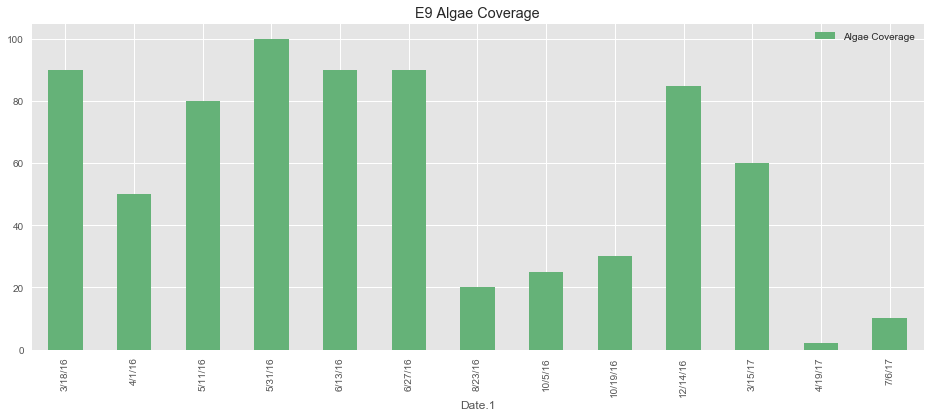

In [74]:
df_E9.plot(x='Date.1', y='Algae Coverage', kind='bar', title='E9 Algae Coverage')

plt.xlabel = 'Date'
plt.savefig('./charts/E9 Algae Coverage.png', dpi=400)

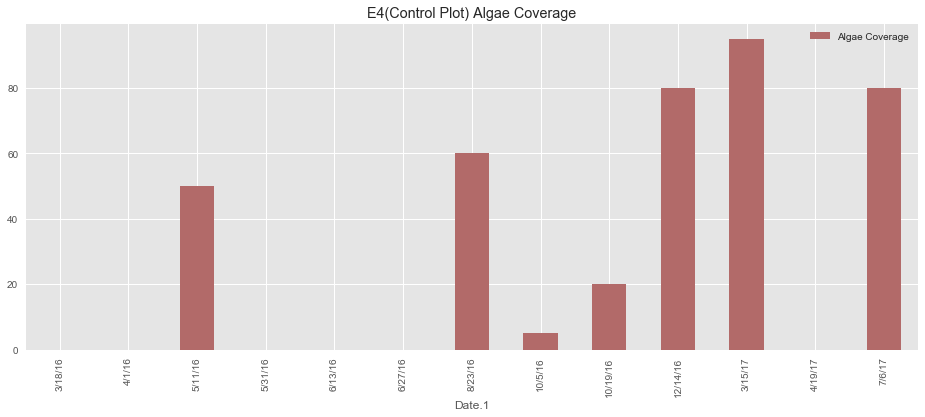

In [75]:
df_E4 = df.loc[df['Units'] == 'E4 (CON)']
df_E4.plot(x='Date.1', y='Algae Coverage', kind='bar', title='E4(Control Plot) Algae Coverage', color='#B26A69') 
plt.savefig('./charts/E4(Control Plot) Algae Coverage.png', dpi=400)

In [395]:
t = df.groupby('is_treatment')['Algae Coverage'].describe()
t

,count,mean,std,min,25%,50%,75%,max
is_treatment,,,,,,,,
0,52.0,21.769231,32.887578,0.0,0.0,0.0,50.0,100.0
1,195.0,49.041026,34.814951,0.0,10.0,50.0,80.0,100.0


In [396]:
t.to_csv('./data/algae-coverage-summary-statistics-control-vs-treatment.csv')

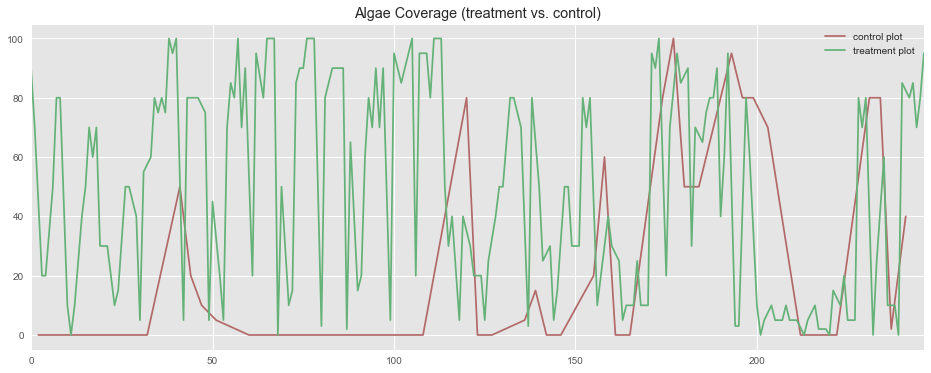

In [76]:
fig, ax = plt.subplots()

for title, group in df.groupby('is_treatment'):
    color = '#65B278' if (group['is_treatment'] > 0).all() else '#B26A69'
    group['Algae Coverage'].plot(legend=True, 
                                 title='Algae Coverage (treatment vs. control)', 
                                 color=color)

ax.legend(["control plot", "treatment plot"]);
plt.savefig('./charts/Algae Coverage (treatment vs. non-treatment).png', dpi=400)

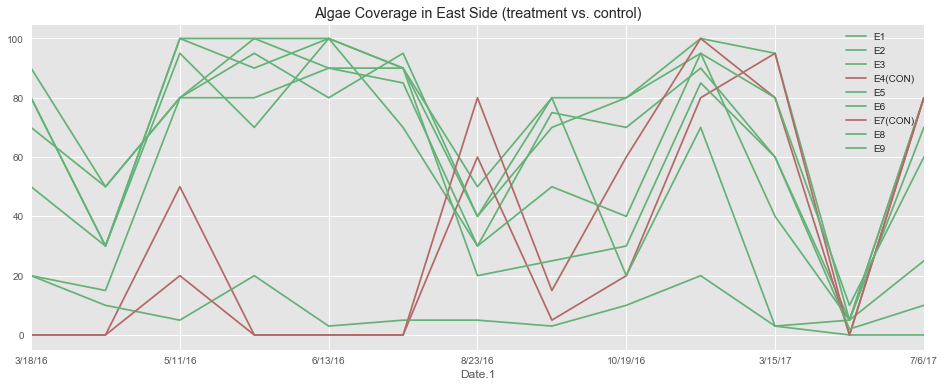

In [65]:
def plot_control_vs_treatment_chart(df, y_col_name, chart_title):
    fig, ax = plt.subplots()
    ax.set_title(chart_title)
    
    for title, group in df.groupby('Units'):
        color = '#65B278' if (group['is_treatment'] > 0).all() else '#B26A69'
        ax = group.plot(x='Date.1', y = y_col_name, ax=ax, color=color)

    if ('W' in df['Units'].iloc[0]):
        ax.legend(["W1(CON)", "W2", "W3", "W4", "W5(CON)", "W6", "W7", "W8", "W9", "W10"], loc='upper right', bbox_to_anchor=(1,1));
    if ('E' in df['Units'].iloc[0]):
        ax.legend(["E1", "E2", "E3", "E4(CON)", "E5", "E6", "E7(CON)", "E8", "E9"], loc='upper right', bbox_to_anchor=(1,1));

    plt.savefig("{}{}{}".format('./charts/', chart_title, '.png'), dpi=400)

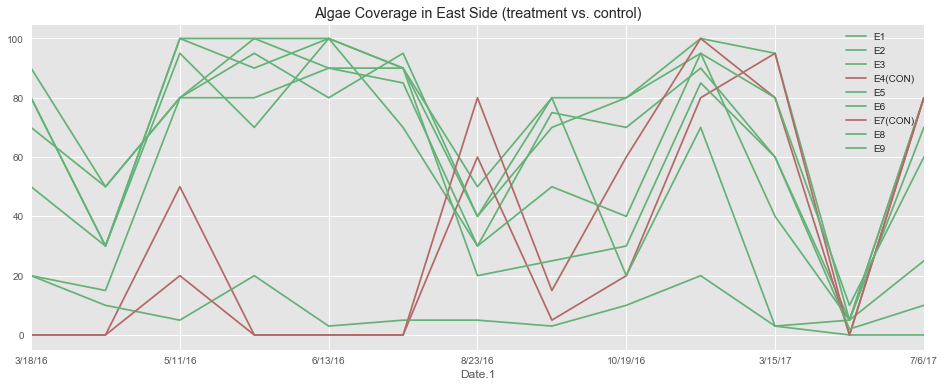

In [66]:
plot_control_vs_treatment_chart(east_df, 'Algae Coverage', 'Algae Coverage in East Side (treatment vs. control)')

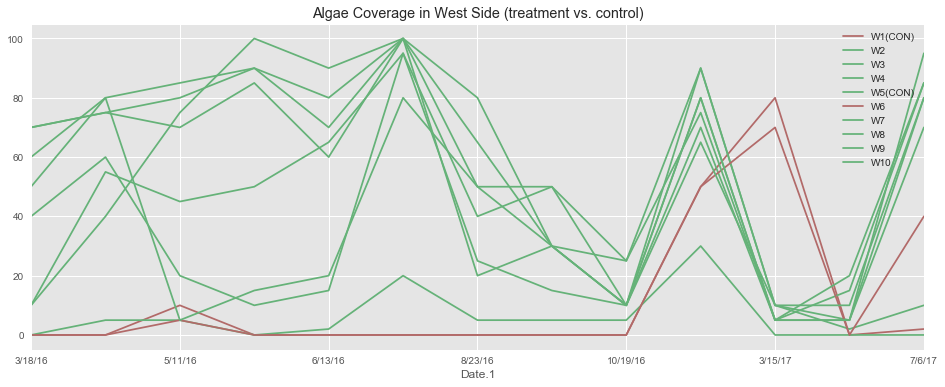

In [67]:
plot_control_vs_treatment_chart(west_df, 'Algae Coverage', 'Algae Coverage in West Side (treatment vs. control)')

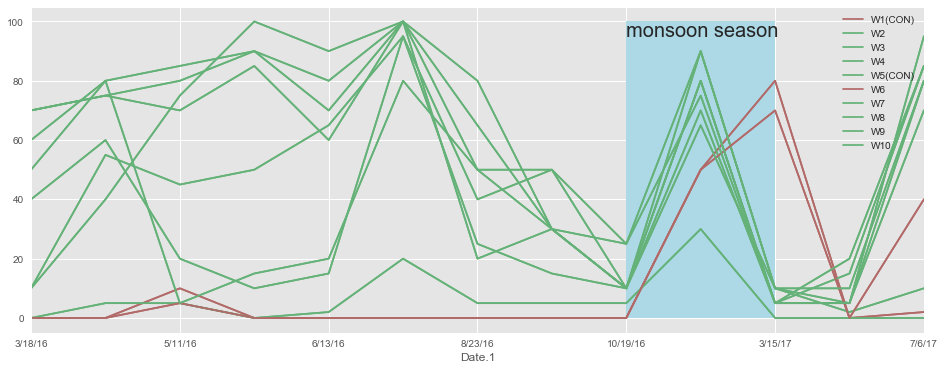

In [72]:
plot_control_vs_treatment_chart_with_monsoon_annotation(west_df, 'Algae Coverage', 'Algae Coverage of West side')
plt.savefig('./charts/Algae Coverage in West side (treatment vs. control).png', dpi=400)

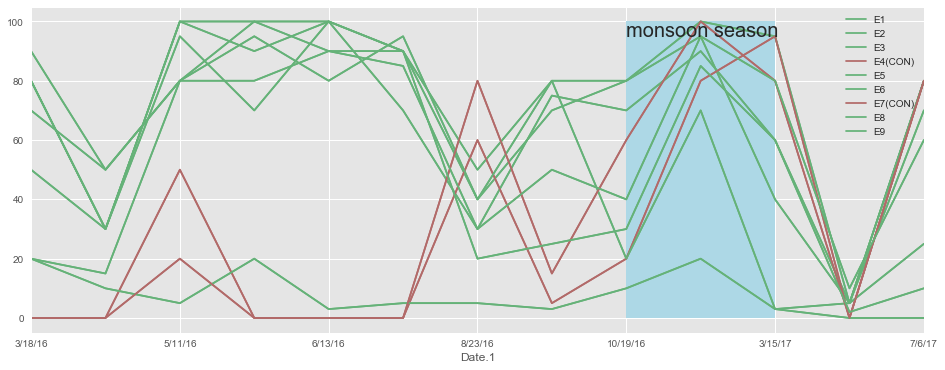

In [73]:
plot_control_vs_treatment_chart_with_monsoon_annotation(east_df, 'Algae Coverage', 'Algae Coverage of East side')
plt.savefig('./charts/Algae Coverage in East side (treatment vs. control).png', dpi=400)

### Species count

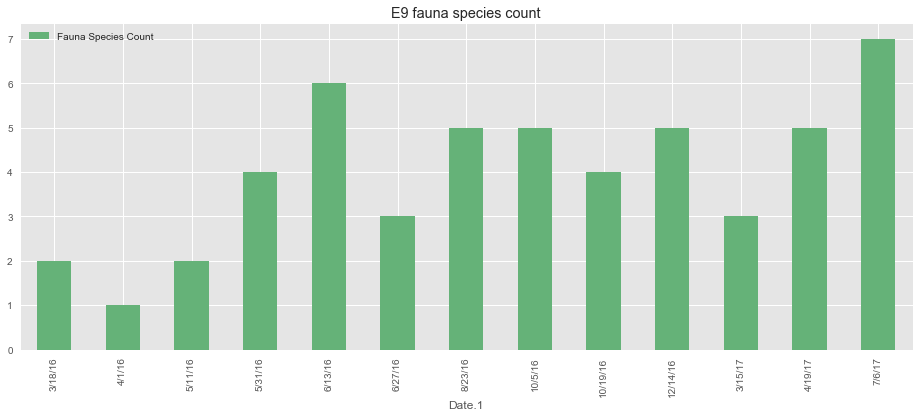

In [68]:
df_E9.plot(x='Date.1', y='Fauna Species Count', kind='bar', title='E9 fauna species count')
plt.savefig('./charts/E9-fauna-species-count.png', dpi=400)

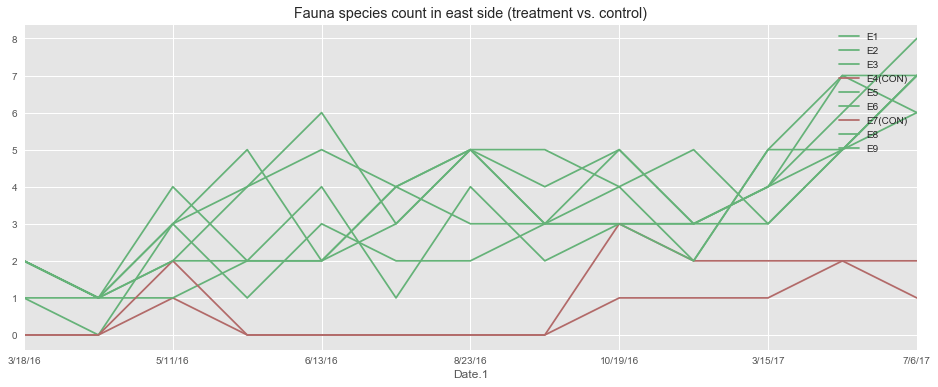

In [77]:
plot_control_vs_treatment_chart(east_df, 'Fauna Species Count', 'Fauna species count in east side (treatment vs. control)')
plt.savefig('./charts/Fauna species count in east side (treatment vs. control).png', dpi=400)

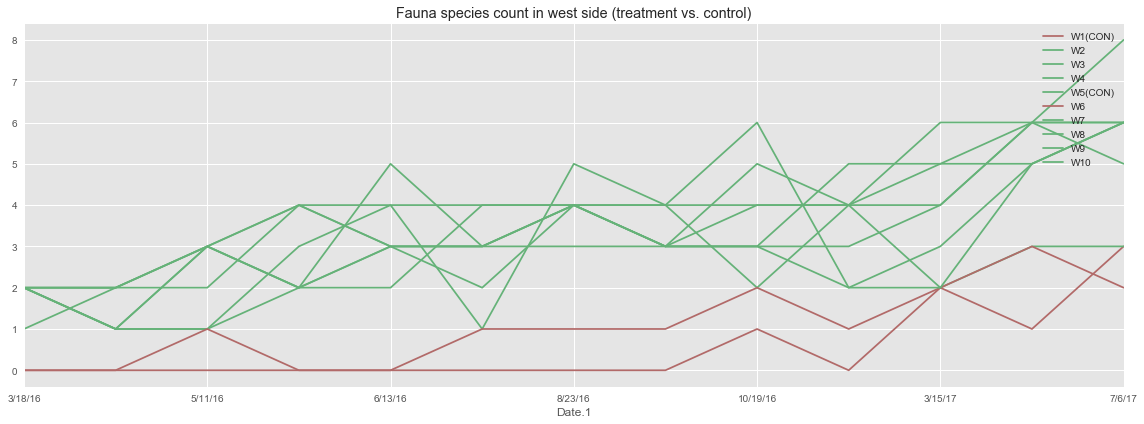

In [78]:
plot_control_vs_treatment_chart(west_df, 'Fauna Species Count', 'Fauna species count in west side (treatment vs. control)')
plt.tight_layout()
plt.savefig('./charts/Fauna species count in west side (treatment vs. control).png', dpi=400)

In [81]:
df_E9_species = df_E9[species_columns]

In [82]:
df_E9['shannons_index'] = df_E9_species.apply(shannon_wrapper_function, axis =1)

/Users/NugNug/anaconda2/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [83]:
df_E9

,Units,Date,Month,Year,Date.1,Time,Temperature,Ph,Algae Coverage,Algae species,Fauna Species,Snails,Nerites,Crabs,Barnacles,Limpets,Landslugs,Tubeworm,Anemone,Shrimps,Bivalves,Ascidians,Sponge,Other,is_treatment,Fauna Species Count,shannons_index
0,E9,18,3,2016,3/18/16,2:30:00 PM,38.4,NaN,90,1,1,2,10,0,0,0,0,0,0,0,0,0,0,0,1,2,0.450561
27,E9,1,4,2016,4/1/16,11:48:00 AM,34.2,9.07,50,1,1,10,0,0,0,0,0,0,0,0,0,0,0,0,1,1,-0.000000
46,E9,11,5,2016,5/11/16,9:25:00 AM,30.0,NaN,80,1,2,10,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0.304636
65,E9,31,5,2016,5/31/16,12:00:00 PM,31.3,9.30,100,1,4,10,0,3,0,0,2,0,1,0,0,0,0,0,1,4,1.040840
84,E9,13,6,2016,6/13/16,11:38:00 AM,33.6,9.06,90,3,3,20,0,3,100,100,2,0,1,0,0,0,0,0,1,6,1.059337
103,E9,27,6,2016,6/27/16,11:30:00 AM,30.9,8.84,90,2,3,0,0,0,23,5,1,0,0,0,0,0,0,0,1,3,0.603035
122,E9,23,8,2016,8/23/16,10:34:00 AM,31.9,NaN,20,2,5,100,0,1,50,30,0,0,1,0,0,0,0,0,1,5,1.038325
141,E9,5,10,2016,10/5/16,6:46:00 PM,29.1,8.83,25,2,4,5,3,0,50,0,0,25,1,0,0,0,0,0,1,5,1.009197
160,E9,19,10,2016,10/19/16,7:23:00 PM,29.2,12.90,30,3,3,18,4,0,0,0,0,70,1,0,0,0,0,0,1,4,0.715755
179,E9,14,12,2016,12/14/16,4:33:00 PM,34.0,9.83,85,3,5,20,15,1,0,0,0,0,1,0,0,1,0,0,1,5,0.991918


In [84]:
species_columns = ['Snails', 'Nerites', 'Crabs', 'Barnacles', 'Limpets', 'Landslugs', 'Tubeworm', 'Anemone', 
                   'Shrimps', 'Bivalves', 'Ascidians', 'Sponge', 'Other']
df_species = df[species_columns]

In [85]:
df['shannons_index'] = df_species.apply(shannon_wrapper_function, axis =1)

In [86]:
df

,Units,Date,Month,Year,Date.1,Time,Temperature,Ph,Algae Coverage,Algae species,Fauna Species,Snails,Nerites,Crabs,Barnacles,Limpets,Landslugs,Tubeworm,Anemone,Shrimps,Bivalves,Ascidians,Sponge,Other,is_treatment,Fauna Species Count,shannons_index
0,E9,18,3,2016,3/18/16,2:30:00 PM,38.4,NaN,90,1,1,2,10,0,0,0,0,0,0,0,0,0,0,0,1,2,0.450561
1,E8,18,3,2016,3/18/16,2:35:00 PM,37.9,NaN,70,1,1,2,20,0,0,0,0,0,0,0,0,0,0,0,1,2,0.304636
2,E7 (CON),18,3,2016,3/18/16,2:40:00 PM,35.2,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
3,E6,18,3,2016,3/18/16,2:45:00 PM,37.9,NaN,20,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,-0.000000
4,E5,18,3,2016,3/18/16,2:50:00 PM,37.8,NaN,20,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,-0.000000
5,E4 (CON),18,3,2016,3/18/16,2:55:00 PM,35.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
6,E3,18,3,2016,3/18/16,3:00:00 PM,38.2,NaN,50,1,1,2,20,0,0,0,0,0,0,0,0,0,0,0,1,2,0.304636
7,E2,18,3,2016,3/18/16,3:05:00 PM,38.1,NaN,80,1,1,2,10,0,0,0,0,0,0,0,0,0,0,0,1,2,0.450561
8,E1,18,3,2016,3/18/16,3:10:00 PM,38.0,NaN,80,1,1,2,10,0,0,0,0,0,0,0,0,0,0,0,1,2,0.450561
9,W1 (CON),18,3,2016,3/18/16,3:15:00 PM,35.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000


In [294]:
df.to_csv('./data/monitoring-data-with-shannons-index.csv')

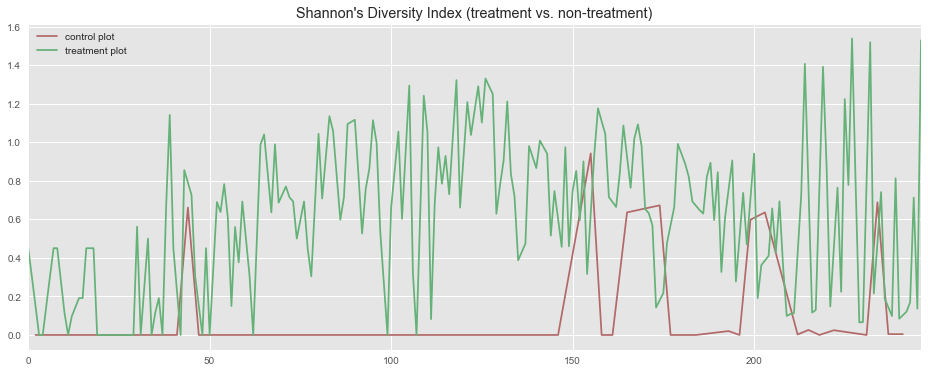

In [87]:
fig, ax = plt.subplots()

for title, group in df.groupby('is_treatment'):
    color = '#65B278' if (group['is_treatment'] > 0).all() else '#B26A69'
    group['shannons_index'].plot(legend=True, 
                                 title='Shannon\'s Diversity Index (treatment vs. non-treatment)', 
                                 color=color)

ax.legend(["control plot", "treatment plot"]);

plt.savefig('./charts/Shannons Diversity Index (treatment vs. non-treatment).png', dpi=400)

## More data visualisation

Treatment groups
- D1a - E5, E6, W3
- D1b - E9, W2, W8, W10
- D2a - E8, W6, W7, W9
- D2b - E1, E2, E3, W4
- CON - E4, E7, W1, W5

In [6]:
df = pd.read_csv('./data/monitoring-data-with-shannons-index.csv', index_col=0)

In [7]:
# df.head()

In [8]:
def classify_group(row):
    if row['Units'] == 'E5' or row['Units'] == 'E6' or row['Units'] == 'W3':
        val = 'D1A'
    elif row['Units'] == 'E9' or row['Units'] == 'W2' or row['Units'] == 'W8' or row['Units'] == 'W10':
        val = 'D1B'
    elif row['Units'] == 'E8' or row['Units'] == 'W6' or row['Units'] == 'W7' or row['Units'] == 'W9':
        val = 'D2A'
    elif row['Units'] == 'E1' or row['Units'] == 'E2' or row['Units'] == 'E3' or row['Units'] == 'W4':
        val = 'D2B'
    elif row['Units'] == 'E4 (CON)' or row['Units'] == 'E7 (CON)' or row['Units'] == 'W1 (CON)' or row['Units'] == 'W5 (CON)':
        val = 'CON'
    else:
        val = 'nil'
    return val

In [9]:
df['treatment_group'] = df.apply(classify_group, axis=1)

In [10]:
df.head()

,Units,Date,Month,Year,Date.1,Time,Temperature,Ph,Algae Coverage,Algae species,Fauna Species,Snails,Nerites,Crabs,Barnacles,Limpets,Landslugs,Tubeworm,Anemone,Shrimps,Bivalves,Ascidians,Sponge,Other,is_treatment,shannons_index,treatment_group
0,E9,18,3,2016,3/18/16,2:30:00 PM,38.4,NaN,90,1,1,2,10,0,0,0,0,0,0,0,0,0,0,0,1,0.450561,D1B
1,E8,18,3,2016,3/18/16,2:35:00 PM,37.9,NaN,70,1,1,2,20,0,0,0,0,0,0,0,0,0,0,0,1,0.304636,D2A
2,E7 (CON),18,3,2016,3/18/16,2:40:00 PM,35.2,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,CON
3,E6,18,3,2016,3/18/16,2:45:00 PM,37.9,NaN,20,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.000000,D1A
4,E5,18,3,2016,3/18/16,2:50:00 PM,37.8,NaN,20,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.000000,D1A


In [11]:
df['treatment_group'].value_counts()

CON    52
D2A    52
D2B    52
D1B    52
D1A    39
Name: treatment_group, dtype: int64

In [12]:
def plot_metric_by_treatment_group(metric, chart_title):
    fig, ax = plt.subplots()
    jet= plt.get_cmap('jet')
    colors = iter(jet(np.linspace(0,1,5)))
    
    for title, group in df.groupby('treatment_group'):
        linewidth = 3 if (group['treatment_group'] == 'CON').all() else 1
        group[metric].plot(legend=True, 
                                     title=chart_title,
                                    label=title,
                                    color=next(colors),
                                    linewidth=linewidth)

    # ax.legend(["control plot", "treatment plot"]);

    plt.savefig('./charts/{}{}'.format(chart_title, '.png'), dpi=400)

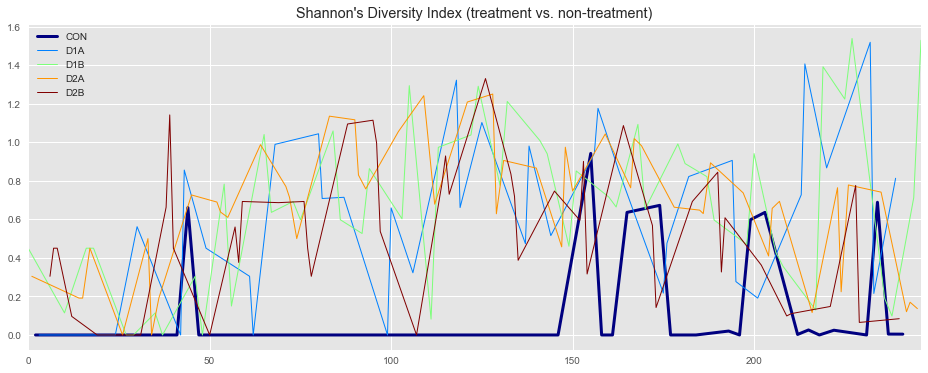

In [95]:
plot_metric_by_treatment_group('shannons_index', 'Shannon\'s Diversity Index (treatment vs. non-treatment)')

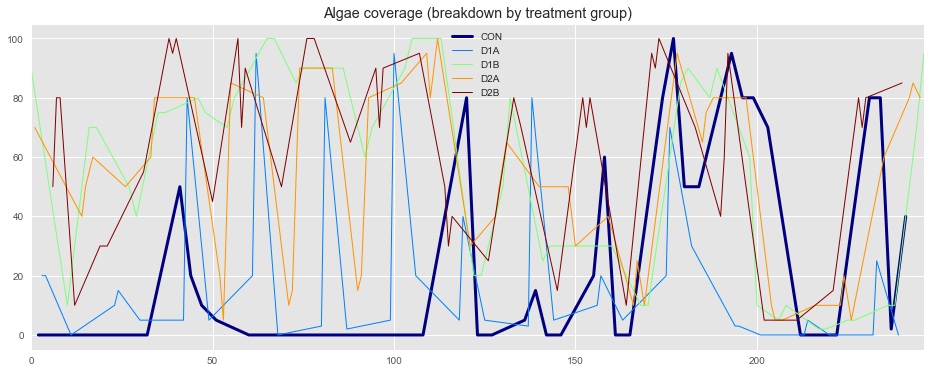

In [96]:
plot_metric_by_treatment_group('Algae Coverage', 'Algae coverage (breakdown by treatment group)')

In [53]:
df

,Units,Date,Month,Year,Date.1,Time,Temperature,Ph,Algae Coverage,Algae species,Fauna Species,Snails,Nerites,Crabs,Barnacles,Limpets,Landslugs,Tubeworm,Anemone,Shrimps,Bivalves,Ascidians,Sponge,Other,is_treatment,shannons_index,treatment_group
0,E9,18,3,2016,3/18/16,2:30:00 PM,38.4,NaN,90,1,1,2,10,0,0,0,0,0,0,0,0,0,0,0,1,0.450561,D1B
1,E8,18,3,2016,3/18/16,2:35:00 PM,37.9,NaN,70,1,1,2,20,0,0,0,0,0,0,0,0,0,0,0,1,0.304636,D2A
2,E7 (CON),18,3,2016,3/18/16,2:40:00 PM,35.2,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,CON
3,E6,18,3,2016,3/18/16,2:45:00 PM,37.9,NaN,20,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.000000,D1A
4,E5,18,3,2016,3/18/16,2:50:00 PM,37.8,NaN,20,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.000000,D1A
5,E4 (CON),18,3,2016,3/18/16,2:55:00 PM,35.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,CON
6,E3,18,3,2016,3/18/16,3:00:00 PM,38.2,NaN,50,1,1,2,20,0,0,0,0,0,0,0,0,0,0,0,1,0.304636,D2B
7,E2,18,3,2016,3/18/16,3:05:00 PM,38.1,NaN,80,1,1,2,10,0,0,0,0,0,0,0,0,0,0,0,1,0.450561,D2B
8,E1,18,3,2016,3/18/16,3:10:00 PM,38.0,NaN,80,1,1,2,10,0,0,0,0,0,0,0,0,0,0,0,1,0.450561,D2B
9,W1 (CON),18,3,2016,3/18/16,3:15:00 PM,35.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,CON


<img src="files/charts/treatment-placement-layout.jpg">

In [13]:
df.columns

Index(['Units', 'Date', 'Month', 'Year', 'Date.1', 'Time', 'Temperature', 'Ph',
       'Algae Coverage', 'Algae species', 'Fauna Species', 'Snails', 'Nerites',
       'Crabs', 'Barnacles', 'Limpets', 'Landslugs', 'Tubeworm', 'Anemone',
       'Shrimps', 'Bivalves', 'Ascidians', 'Sponge', 'Other', 'is_treatment',
       'shannons_index', 'treatment_group'],
      dtype='object')

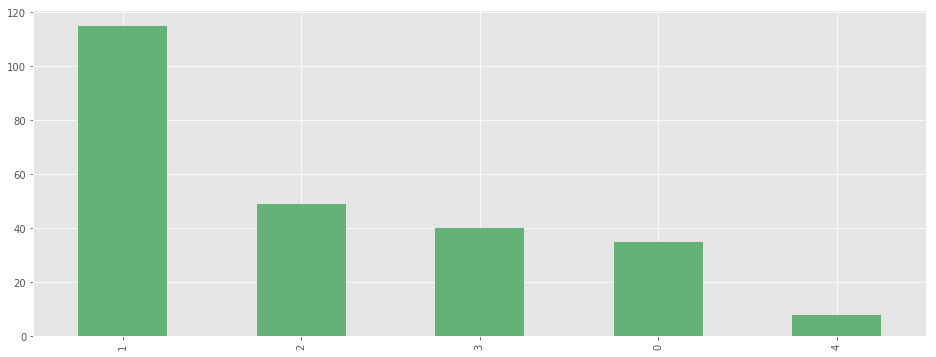

In [16]:
df['Algae species'].value_counts().plot.bar()

In [23]:
import seaborn as sns

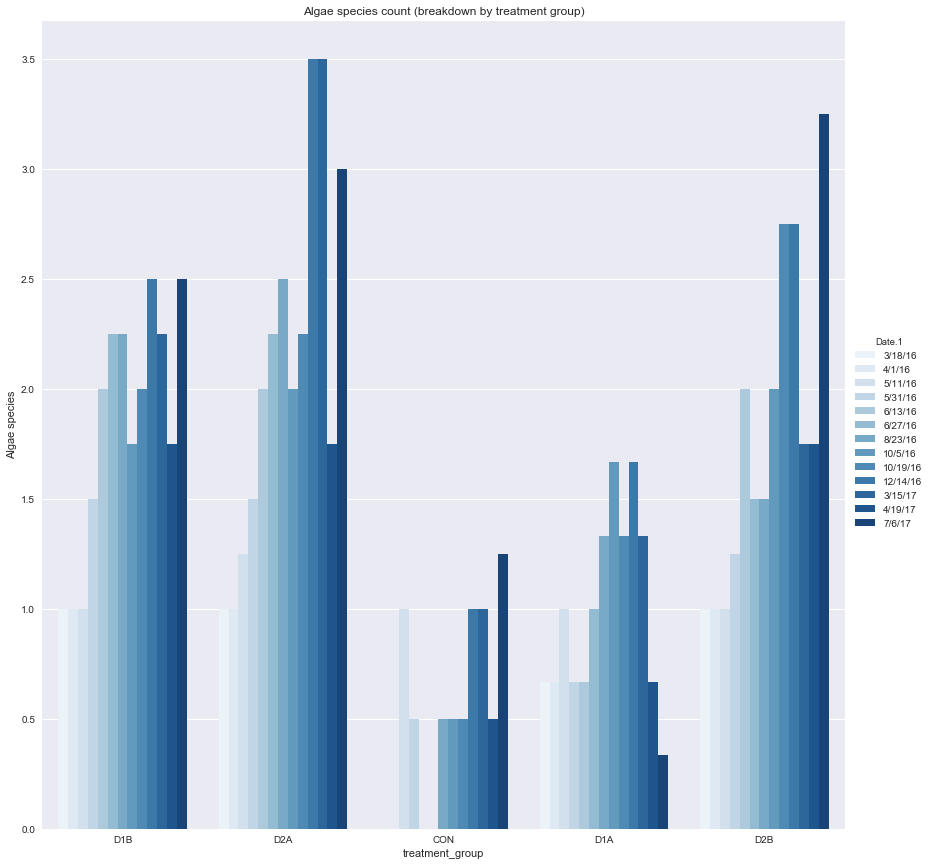

In [46]:
sns.color_palette("Blues")
sns.factorplot(x="treatment_group", y="Algae species", hue="Date.1", data=df,
                   size=12, kind="bar", palette="Blues", ci=None)
# g.despine(left=True)
# g.set_ylabels("survival probability")
plt.title('Algae species count (breakdown by treatment group)')

plt.savefig('./charts/Algae species count (breakdown by treatment group).png', dpi=400)

# Building a model

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
pd.options.display.max_columns = 40

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

### Data pre-processing

In [58]:
df_rainfall = pd.read_csv('./data/daily-rainfall-2016-03-18-to-2017-07-06.csv', encoding = "ISO-8859-1", index_col = 0)

In [61]:
df.head()

,Units,Date,Month,Year,Date.1,Time,Temperature,Ph,Algae Coverage,Algae species,Fauna Species,Snails,Nerites,Crabs,Barnacles,Limpets,Landslugs,Tubeworm,Anemone,Shrimps,Bivalves,Ascidians,Sponge,Other,is_treatment,shannons_index,treatment_group
0,E9,18,3,2016,3/18/16,2:30:00 PM,38.4,NaN,90,1,1,2,10,0,0,0,0,0,0,0,0,0,0,0,1,0.450561,D1B
1,E8,18,3,2016,3/18/16,2:35:00 PM,37.9,NaN,70,1,1,2,20,0,0,0,0,0,0,0,0,0,0,0,1,0.304636,D2A
2,E7 (CON),18,3,2016,3/18/16,2:40:00 PM,35.2,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,CON
3,E6,18,3,2016,3/18/16,2:45:00 PM,37.9,NaN,20,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.000000,D1A
4,E5,18,3,2016,3/18/16,2:50:00 PM,37.8,NaN,20,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.000000,D1A


In [62]:
df['Date.1'].value_counts()

6/13/16     19
10/5/16     19
8/23/16     19
7/6/17      19
12/14/16    19
4/1/16      19
3/15/17     19
3/18/16     19
5/31/16     19
6/27/16     19
4/19/17     19
5/11/16     19
10/19/16    19
Name: Date.1, dtype: int64

In [116]:
df['month_rainfall']= np.where((df['Month'] == 4) & (df['Year'] == 2017), 210.4, df['month_rainfall'])

df['month_rainfall'].value_counts()

193.8    38
163.2    38
181.0    38
210.4    19
136.6    19
6.2      19
89.8     19
292.6    19
139.2    19
80.0     19
Name: month_rainfall, dtype: int64

In [117]:
df.to_csv('./data/monitoring-data-with-shannons-index-and-rainfall.csv')

In [151]:
df = pd.read_csv('./data/monitoring-data-with-shannons-index-and-rainfall.csv')

In [173]:
df_for_modelling = df[['Temperature', 'Algae Coverage', 'treatment_group', 'month_rainfall']]
# 'Algae species', 'Fauna Species', 

In [174]:
one_hot_encoded_treatments_df = pd.get_dummies(df_for_modelling['treatment_group'])

In [175]:
df_for_modelling = df_for_modelling.drop('treatment_group', axis=1)
df_for_modelling = df_for_modelling.join(one_hot_encoded_treatments_df);

In [178]:
X = df_for_modelling.iloc[:, df_for_modelling.columns != 'Algae Coverage'].values
y = df_for_modelling.iloc[:, df_for_modelling.columns == 'Algae Coverage'].values.ravel()

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [180]:
model_1 = LinearRegression()
model_1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [182]:
evaluate_model(model_1, X, y)

{'model name': 'LinearRegression',
 'r2_score': 0.24011629608075746,
 'root_mean_squared_error': 31.417228736571008}

In [183]:
from sklearn.ensemble import RandomForestRegressor

In [184]:
model_2 = RandomForestRegressor()
model_2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [185]:
evaluate_model(model_2, X, y)

{'model name': 'RandomForestRegressor',
 'r2_score': 0.74653742828148251,
 'root_mean_squared_error': 18.144759951815722}

In [24]:
plot_feature_importances(model_2, df_for_modelling)

NameError: name 'model_2' is not defined

In [190]:
from sklearn.tree import DecisionTreeRegressor

model_3 = DecisionTreeRegressor()
model_3.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [191]:
evaluate_model(model_3, X, y)

{'model name': 'DecisionTreeRegressor',
 'r2_score': 0.77317876341915048,
 'root_mean_squared_error': 17.16469794667357}

[(0.4323635540747926, 'Temperature'), (0.28579905971527803, 'month_rainfall'), (0.11973181373321107, 'CON'), (0.095674464884280386, 'D1A'), (0.03231115589416908, 'D1B'), (0.026664566937075543, 'D2A'), (0.0074553847611933096, 'D2B')]


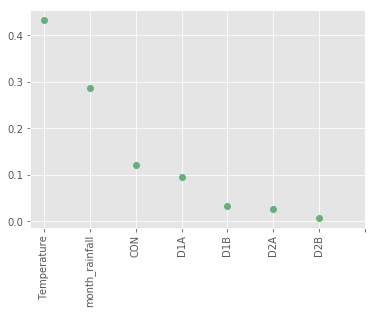

In [194]:
plot_feature_importances(model_3, df_for_modelling)

### Modelling using only is_treatment

In [3]:
df = pd.read_csv('./data/monitoring-data-with-shannons-index-and-rainfall.csv')

In [4]:
df_for_modelling_2 = df[['Temperature', 'Algae Coverage', 'is_treatment', 'month_rainfall']]

In [8]:
X_2 = df_for_modelling_2.iloc[:, df_for_modelling_2.columns != 'Algae Coverage'].values
y_2 = df_for_modelling_2.iloc[:, df_for_modelling_2.columns == 'Algae Coverage'].values.ravel()

In [11]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state=0)

In [12]:
model_4 = LinearRegression()
model_4.fit(X_train_2, y_train_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
evaluate_model(model_4, X_2, y_2)

{'model name': 'LinearRegression',
 'r2_score': 0.11741130042521086,
 'root_mean_squared_error': 33.858950288649687}

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
model_5 = RandomForestRegressor()
model_5.fit(X_train_2, y_train_2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [20]:
evaluate_model(model_5, X_2, y_2)

{'model name': 'RandomForestRegressor',
 'r2_score': 0.66096425939766812,
 'root_mean_squared_error': 20.985390261498701}